In [19]:
include("ProbsEWA.jl")
using Flux, .pEWA, Random, IterTools, ProgressMeter, DataFrames, CSV, Statistics, Plots, BSON

# Game setup
coord = [[[5 1; 1 4], [5 1; 1 4]], pEWA.find_NE_mixed([[5 1; 1 4], [5 1; 1 4]])]
dom = [[[1 3; 0 2],[1 0; 3 2]], pEWA.find_NE_mixed([[1 3; 0 2],[1 0; 3 2]])]
cyclic = [[[5 1; 1 4], [-5 1; 1 -4]], pEWA.find_NE_mixed([[5 1; 1 4], [-5 1; 1 -4]])]

# Model definition
deepEWA = Chain(
    Dense(12 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 4)
)

# Save model
BSON.@load "model_games.bson" deepEWA

points = 10_000

10000

In [20]:
# Visualization
custom_palette = [RGB(0.9, 0.1, 0.1), RGB(0.1, 0.7, 0.1), RGB(1.0, 1.0, 0.0), RGB(0.3, 0.8, 0.8)]

# Parameter sampling
α_grid, κ_grid, δ_grid = [rand(0.0:0.0001:1.0, points) for _ in 1:3]
β_grid = exp.(rand(-0.5:0.001:1.5, points))
mat1s = [rand(0:10, 2, 2) for _ in 1:points]
mat2s = [rand(0:10, 2, 2) for _ in 1:points]
combs = [[α_grid[i], κ_grid[i], δ_grid[i], β_grid[i], mat1s[i], mat2s[i]] for i in 1:points]

# Split data
x_test = combs
y_test = Vector{Int}(undef, points)

# Feature flattening
function flatten_features(data)
    hcat([Float32.(vcat(x[1:4], vec(x[5]), vec(x[6]))) for x in data]...)
end

x_test = flatten_features(x_test)


12×10000 Matrix{Float32}:
 0.7288   0.263     0.1936    0.0498   …  0.3199  0.3237   0.2023   0.0622
 0.9972   0.7971    0.4467    0.9601      0.3802  0.947    0.3746   0.0295
 0.4869   0.6411    0.342     0.8947      0.0756  0.8399   0.747    0.447
 3.15504  2.07716   3.71359   1.31128     2.8806  1.19125  1.23491  3.77726
 6.0      0.0       6.0       3.0         1.0     0.0      3.0      4.0
 9.0      5.0       5.0       2.0      …  6.0     3.0      2.0      1.0
 7.0      1.0       1.0       7.0         7.0     4.0      1.0      0.0
 9.0      0.0      10.0       7.0         6.0     4.0      2.0      9.0
 0.0      3.0       2.0       6.0         3.0     2.0      7.0      7.0
 1.0      2.0       5.0      10.0         6.0     3.0      0.0      7.0
 9.0      4.0       6.0       8.0      …  8.0     6.0      8.0      9.0
 6.0      3.0       1.0       1.0         9.0     0.0      9.0      8.0

In [21]:
# Evaluation on new game
game = coord
game_name = "dom"

"dom"

In [22]:
alpha_fix = 0.0
beta_fix = -1.0
kappa_fix = 1.0
delta_fix = -1.0

if alpha_fix != -1.0
    x_test[1, :] .= alpha_fix
end
if kappa_fix != -1.0
    x_test[2, :] .= kappa_fix
end
if delta_fix != -1.0
    x_test[3, :] .= delta_fix
end
if beta_fix != -1.0
    x_test[4, :] .= beta_fix
end


@showprogress for i in 1:size(x_test, 2)
    α, κ, δ, β = Float64.(x_test[1:4, i])
    params = pEWA.init_pEWA(; α, κ, δ, β, game=game)
    y_test[i] = pEWA.multicat_pEWA(params)
end

out_new = deepEWA(x_test)
probs_new = softmax(out_new, dims=1)
predicted_labels_new = Flux.onecold(probs_new, 1:4)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


10000-element Vector{Int64}:
 4
 3
 3
 2
 3
 3
 3
 3
 4
 3
 3
 4
 2
 ⋮
 3
 4
 4
 2
 2
 2
 3
 4
 3
 2
 2
 4

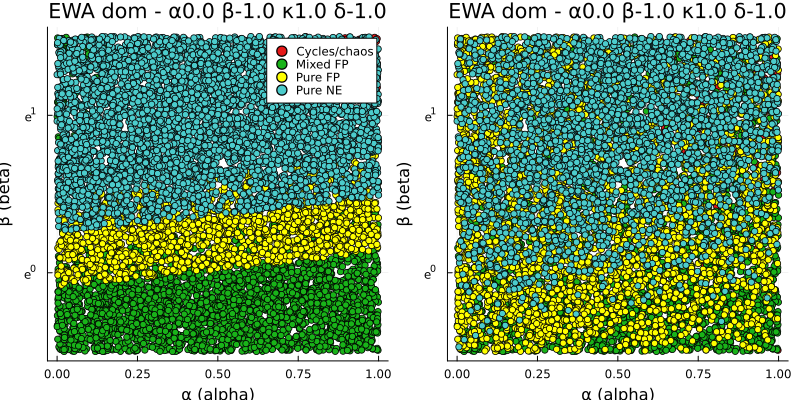

In [ ]:
# First, find unique group IDs
mapping = Dict(
    1 => "Cycles/chaos",
    2 => "Mixed FP",
    3 => "Pure FP",
    4 => "Pure NE"
)
# Create a mapping from group IDs to labels


unique_groups = sort(collect(keys(mapping)))  # or `sort(unique(y_test))`

# Plot TRUE convergence
p_true_new = plot(title="True convergence", legend=true,
    xlabel="α (alpha)", ylabel="β (beta)", yscale=:ln,
    palette=custom_palette)

for group_id in unique_groups
    idxs = findall(y_test .== group_id)
    scatter!(p_true_new, x_test[3, idxs], x_test[4, idxs],
        label=mapping[group_id], markersize=3.5)
end

# Plot PREDICTED convergence
p_pred_new = plot(title="Predicted convergence", legend=false,
    xlabel="α (alpha)", ylabel="β (beta)", yscale=:ln,
    palette=custom_palette)

for group_id in unique_groups
    idxs = findall(predicted_labels_new .== group_id)
    scatter!(p_pred_new, x_test[3, idxs], x_test[4, idxs],
        label=mapping[group_id], markersize=3.5)
end

# Combine and save
plot(p_true_new, p_pred_new, layout=(1, 2), size=(800, 400)
savefig("EWA_$(game_name)_a$(alpha_fix)_b$(beta_fix)_d$(delta_fix)_k$(kappa_fix).png")


In [24]:
accuracy_new = mean(predicted_labels_new .== y_test)

0.5002